# Support Vector Regression for Rogue Wave Prediction

In this notebook, we model rogue wave characteristics using a Support Vector Machine (SVM) regressor. SVMs are powerful supervised learning algorithms that can capture both linear and non-linear relationships depending on the choice of kernel function. They are particularly well-suited for high-dimensional feature spaces and are robust to outliers due to their margin-based optimization framework. By focusing on minimizing prediction error only outside a certain margin (epsilon), SVMs can model complex patterns without overfitting, making them a valuable alternative to tree-based and linear models when the signal is subtle or highly non-linear.

Before training, we standardize the input features using `StandardScaler`, as SVMs are sensitive to the scale of input variables. Feature scaling ensures that the kernel function operates consistently across dimensions and improves both convergence and generalization.

Hyperparameter tuning is performed using k-fold cross-validation with a stratified splitting strategy. Stratification ensures that the rare rogue wave events are well represented in each fold, which is important for stable performance evaluation and fair training-validation distribution.

We tune the following hyperparameters to control model complexity, generalization, and kernel behavior:

- `kernel = ['rbf']`: Specifies the kernel function used to transform the input space. The Radial Basis Function (RBF) kernel is highly flexible and effective for non-linear data.
- `C = [0.1, 1, 10]`: The regularization parameter controlling the trade-off between model complexity and margin size. Smaller values of `C` encourage wider margins (more regularization), while larger values allow the model to fit the training data more closely. We test a logarithmic scale to capture both conservative and flexible regimes.
- `gamma = ['auto', 0.01, 0.1, 1]`: Controls the influence of individual training points for RBF kernels. `auto` is data-driven default, while explicit values offer finer control. This range allows us to balance model flexibility and smoothness.
- `epsilon = [0.01, 0.1, 0.2]`: Defines the margin of tolerance within which no penalty is applied in the loss function. Smaller values increase sensitivity to small errors, while larger values allow for coarser approximations and greater robustness.

Since the dataset is very large for training an SVM model, we use the ThunderSVM package, which allows to train the model much faster on GPU. One given limitation is that the model needs a GPU for inference as well since the number of support vectors is very large. 

To evaluate model performance, we compute multiple regression metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), R² score, and Spearman correlation. MSE penalizes large errors more severely and is sensitive to outliers, while MAE provides a more robust measure of average prediction error. The R² score indicates how much variance in the target is explained by the model, and Spearman correlation assesses whether the model preserves the rank ordering of the predictions, a useful complement to R² when dealing with non-linearities or monotonic relationships.

For interpretability, we apply SHAP (SHapley Additive exPlanations) using the `KernelExplainer`. Unlike tree-based or linear SHAP explainers, `KernelExplainer` is model-agnostic and well-suited for black-box models such as SVMs. It approximates Shapley values using a local surrogate model around each prediction and integrates over a background dataset to marginalize out feature contributions. This allows us to extract meaningful insights even when the internal structure of the model is not directly accessible.

We compute SHAP values for both the training and test sets. Therefore, we use a background dataset of 200 randomly sampled waves and estimate the SHAP values from 160,000 and 40,000 waves for the training and test set, respectively. SHAP values on the training data reflect the model's learned dependencies, while test set explanations highlight how well these generalize to unseen examples. Comparing them helps assess overfitting and provides insight into which features consistently drive model predictions across both in-sample and out-of-sample data.

In [1]:
%load_ext autoreload
%autoreload 2

**Imports**

In [2]:
import os
import sys
import pickle
import shap

import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


sys.path.append('./')
sys.path.append('../scripts/')
import utils

**Parameter Settings**

In [3]:
n_jobs = 5
print(f"Using {n_jobs} cores from {os.cpu_count()} available cores.") # how many CPU cores are available on the current machine

Using 5 cores from 8 available cores.


In [4]:
seed = 42
num_cv = 5

In [5]:
hyperparameter_grid = {
    'kernel': ['rbf'],  # RBF is flexible for non-linear patterns
    'C': [0.1, 1, 10],  # Regularization strength (low = more regularization)
    'gamma': ['auto', 0.01, 0.1, 1],  # Kernel coefficient for 'rbf'
    'epsilon': [0.01, 0.1, 0.2]  # Margin of tolerance where no penalty is given
}

**Data Loading**

We load the data that was preprocessed in `01_data_processing.ipynb`.  

In [6]:
file_data = "../data/data_train_test.pickle"  # path to the preprocessed data
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(file_data)

Loading data...

Training dataset target distribution:
Counter({1: 489544, 0: 334909, 2: 14264})

Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})


**Data Standardization**

In [7]:
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

**Model Training**

In [8]:
# Run CV
# we run the svm model on GPU using the script run_svm_regression.py and load the cross-validation results here
cv_results = pd.read_csv("../results/svm/cv_results.csv", index_col=0)  

In [9]:
cv_results.sort_values(by="score", ascending=False, inplace=True)
cv_results

,C,epsilon,gamma,kernel,score
3,10.0,0.01,1.0,rbf,0.947478
4,1.0,0.01,1.0,rbf,0.931051
5,0.1,0.01,1.0,rbf,0.881896
0,10.0,0.10,1.0,rbf,0.845505
1,1.0,0.10,1.0,rbf,0.832365
2,0.1,0.10,1.0,rbf,0.784952
15,10.0,0.01,0.1,rbf,0.732349
16,10.0,0.10,0.1,rbf,0.700032
12,1.0,0.01,0.1,rbf,0.591583
30,10.0,0.01,auto,rbf,0.585040


In [10]:
# Load model and data
model, X_train, y_train, y_train_cat, X_test, y_test, y_test_cat = utils.load_data_and_model("../results/svm/model_and_data.pickle", output=False)

Training dataset target distribution:
Counter({1: 489544, 0: 334909, 2: 14264})
Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})


In [11]:
print("Number of support vectors:", len(model.support_))

Number of support vectors: 359574


In [15]:
# Load and unpack the train and test predictions
with open("../results/svm/performance_train.pickle", "rb") as handle:
    performance_train = pickle.load(handle)

y_true_train, y_pred_train, mse_train, mae_train, r2_train, spearman_r_train = performance_train

with open("../results/svm/performance_test.pickle", "rb") as handle:
    performance_test = pickle.load(handle)

y_true_test, y_pred_test, mse_test, mae_test, r2_test, spearman_r_test = performance_test

**Model Evaluation**

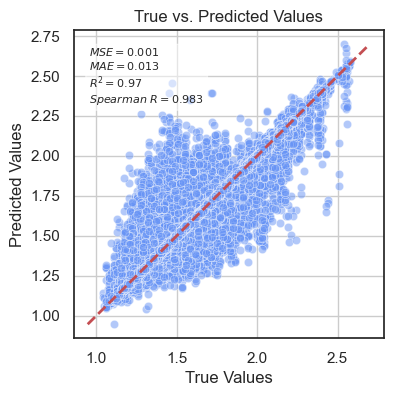

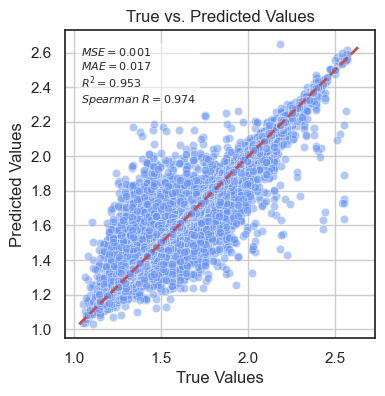

In [16]:
# Evaluate model on train and test set
utils.plot_predictions(y_true_train, y_pred_train, textstr = f"$MSE={mse_train}$\n$MAE={mae_train}$\n$R^2={r2_train}$\n$Spearman\\ R={spearman_r_train}$")
utils.plot_predictions(y_true_test, y_pred_test, textstr = f"$MSE={mse_test}$\n$MAE={mae_test}$\n$R^2={r2_test}$\n$Spearman\\ R={spearman_r_test}$")

**Model Interpretation**